In [1]:
import numpy as np
from pathlib import Path
from datetime import datetime
import pytz

import pandas as pd

#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.tri as tri

from sklearn.decomposition import PCA

from astropy import units as u
from astropy.io import ascii, fits

from mmtwfs.zernike import ZernikeVector

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
ACT = 104 # number of active actuators
NODE = 3222 # number of FE nodes in BCV analysis
BRAD = 3228.5 # radius of M1 in mm

In [3]:
# matrix to convert a phase surface calculated at each BCV node into a vector of actuator force commands
# this version uses the first 32 modes from an SVD analysis.
# surface units are nm, actuator force commands are in Newtons
surf2act = np.fromfile("../mmtwfs/data/Surf2ActTEL_32.bin", dtype=np.float32).reshape(ACT, NODE).T

# coordinates of the BCV FE nodes
nodecoor = ascii.read(
    "../mmtwfs/data/bcv_node_coordinates.dat",
    names=["bcv_id", "bcv_x", "bcv_y", "bcv_z"]
)

# coordinates of the actuators
actcoor = ascii.read(
    "../mmtwfs/data/actuator_coordinates.dat",
    names=["act_i", "act_x", "act_y", "act_type"]
)

# add index to be able to query by actuator number
actcoor.add_index("act_i")

# convert BCV coordinates to a unit circle
for ax in ["bcv_x", "bcv_y"]:
    nodecoor[ax] /= BRAD

# calculate polar coordinates for the BCV nodes
nodecoor['bcv_rho'] = np.sqrt(nodecoor['bcv_x']**2 + nodecoor['bcv_y']**2)
nodecoor['bcv_phi'] = np.arctan2(nodecoor['bcv_y'], nodecoor['bcv_x'])

# full 104 mode matrix to convert a phase surface calculated at each BCV node
# into a vector of actuator force commands
surf2act_full = np.loadtxt("../mmtwfs/data/Surf2ActTEL_104").T

# matrix to convert a force vector in unit of Newtons into a phase surface
# at each BCV node in units of nm
act2surf = np.loadtxt("../mmtwfs/data/Act2SurfTEL").T

In [43]:
def plot_actuator_influence(act_id, force=1.0):
    """
    Plot the phase surface created by applying <force> Newtons to actuator `act_id`.
    """
    actuator_info = actcoor.loc[act_id]
    actuator = actuator_info['act_i']
    # this maps act_id to force vector index
    act_index = actcoor['act_i'].searchsorted(actuator)
    fig, ax = plt.subplots()
    fig.set_label(f"Actuator ID: {actuator}")
    fvec = np.zeros(ACT)
    fvec[act_index] = force
    ph = fvec @ act2surf
    X, Y = nodecoor['bcv_x'].value, nodecoor['bcv_y'].value
    triang = tri.Triangulation(X, Y)
    # Mask off hole in center of mirror
    triang.set_mask(
        np.hypot(
            X[triang.triangles].mean(axis=1),
            Y[triang.triangles].mean(axis=1)
        ) < np.min(nodecoor['bcv_rho'])
    )
    ax.set_aspect('equal')
    vmax = np.ceil(np.max(np.abs(ph))+1)
    vmin = -vmax+1
    levels = np.arange(vmin, vmax)
    tcf = ax.tricontourf(triang, ph, vmax=vmax, vmin=vmin, levels=levels, cmap=cm.RdBu)
    ax.set_axis_off()
    fig.colorbar(tcf, ax=ax, label='Surface Displacement (nm)')
    ax.tricontour(triang, ph, vmax=vmax, vmin=vmin, levels=levels, colors='k')
    xcor = actcoor['act_x']/BRAD
    ycor = actcoor['act_y']/BRAD
    ax.scatter(xcor, ycor, marker='.', color='black')
    for i, (x, y) in enumerate(zip(xcor, ycor)):
        ax.text(
            x,
            y + 0.02,
            actcoor["act_i"][i],
            horizontalalignment="center",
            verticalalignment="bottom",
            size="xx-small",
            color="black"
        )
    ax.scatter(actuator_info['act_x']/BRAD, actuator_info['act_y']/BRAD, color='lime', marker='*')
    return fig

def plot_force_influence(forces, inf_matrix=act2surf):
    """
    Plot the phase surface created by applying force vector to M1.
    """
    fig, ax = plt.subplots()
    max_i, min_i = actcoor[forces.argmax()]['act_i'], actcoor[forces.argmin()]['act_i']
    fig.set_label(f"Forces: Max={np.max(forces):.1f} N (Actuator {max_i}), Min={np.min(forces):.1f} N (Actuator {min_i}), RMS={np.std(forces):.1f} N")
    ph = forces @ inf_matrix
    X, Y = nodecoor['bcv_x'].value, nodecoor['bcv_y'].value
    triang = tri.Triangulation(X, Y)
    # Mask off hole in center of mirror
    triang.set_mask(
        np.hypot(
            X[triang.triangles].mean(axis=1),
            Y[triang.triangles].mean(axis=1)
        ) < np.min(nodecoor['bcv_rho'])
    )
    ax.set_aspect('equal')
    tcf = ax.tricontourf(triang, ph, cmap=cm.RdBu, alpha=0.5)
    ax.set_axis_off()
    fig.colorbar(tcf, ax=ax, label='Surface Displacement (nm)')
    ax.tricontour(triang, ph, colors='k', alpha=0.2)
    xcor = actcoor['act_x']/BRAD
    ycor = actcoor['act_y']/BRAD
    ax.scatter(xcor, ycor, marker='.', color='black')
    for i, (x, y) in enumerate(zip(xcor, ycor)):
        ax.text(
            x,
            y + 0.02,
            actcoor["act_i"][i],
            horizontalalignment="center",
            verticalalignment="bottom",
            size="xx-small",
            color="black"
        )
    return fig

def zernike_surface(zv=ZernikeVector()):
    """
    Calculate phase surface at the BCV node positions for a given ZernikeVector `zv`.
    Displacements are in nm.
    """
    # convert to nm...
    zv.units = u.nm

    # make sure we're not Noll normalized...
    zv.denormalize()

    # need to rotate the wavefront -90 degrees to match the BCV angle convention of +Y being 0 deg.
    zv.rotate(-90 * u.deg)

    # get surface displacements at the BCV node positions. multiply the wavefront amplitude by 0.5 to account for
    # reflection off the surface.
    surface = (
        -0.5 * zv.total_phase(nodecoor["bcv_rho"], nodecoor["bcv_phi"])
    )

    return surface.to(u.nm).value

def plot_phase_surface(zsurf):
    """
    Plot a phase surface <zsurf> that was calculated at the BCV node positions.
    """
    fig, ax = plt.subplots()
    fig.set_label("M1 Surface")
    X, Y = nodecoor['bcv_x'].value, nodecoor['bcv_y'].value
    triang = tri.Triangulation(X, Y)
    # Mask off hole in center of mirror
    triang.set_mask(
        np.hypot(
            X[triang.triangles].mean(axis=1),
            Y[triang.triangles].mean(axis=1)
        ) < np.min(nodecoor['bcv_rho'])
    )
    ax.set_aspect('equal')
    tcf = ax.tricontourf(triang, zsurf, cmap=cm.RdBu)
    ax.set_axis_off()
    fig.colorbar(tcf, ax=ax, label='Surface Displacement (nm)')
    ax.tricontour(triang, zsurf, colors='k')
    return fig

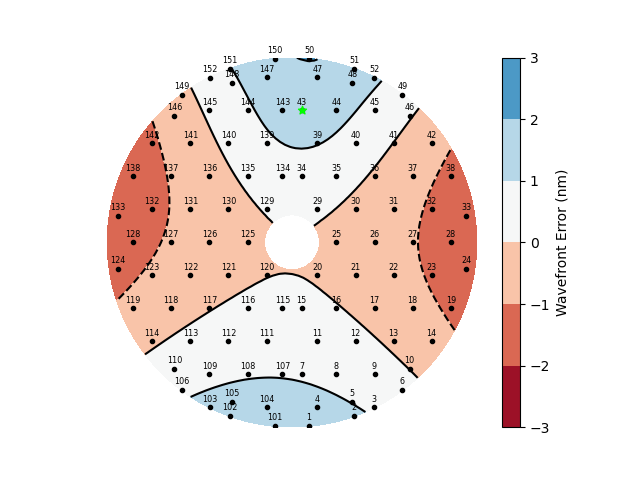

In [5]:
fig = plot_actuator_influence(43, force=1)


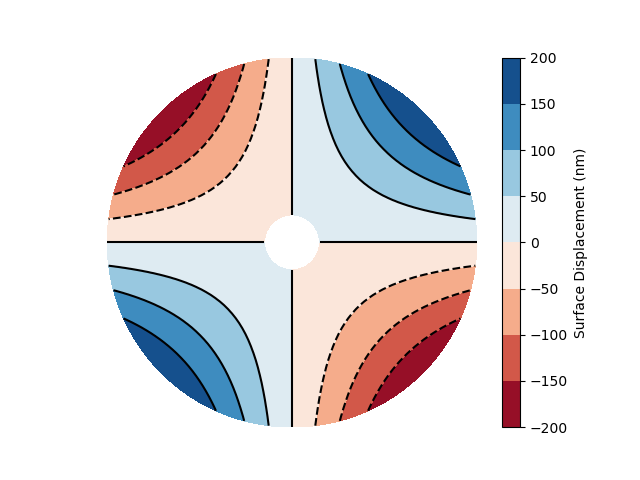

In [6]:
zv = ZernikeVector(Z05=400*u.nm)
zsurf = zernike_surface(zv)
fig = plot_phase_surface(zsurf)

In [7]:
# create matrix of surfaces for all actuators
act_surfaces = np.identity(ACT) @ act2surf
# perform PCA on the actuator surfaces to generate a reduced basis of bending modes
pca = PCA(n_components=13).fit(act_surfaces)

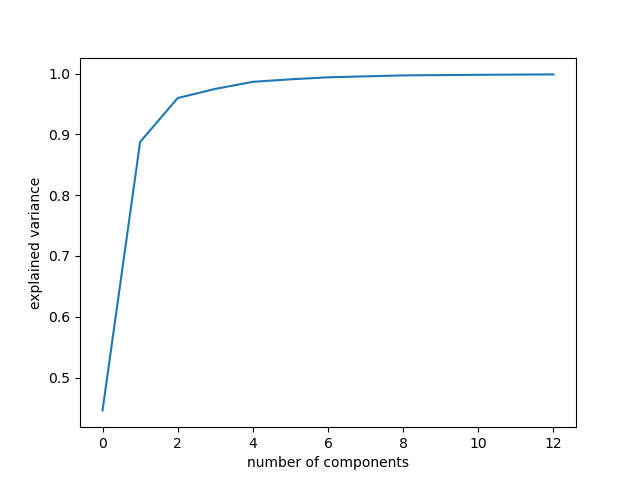

np.float64(0.9985674113716128)

In [8]:
vr = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(vr)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()
vr[-1]

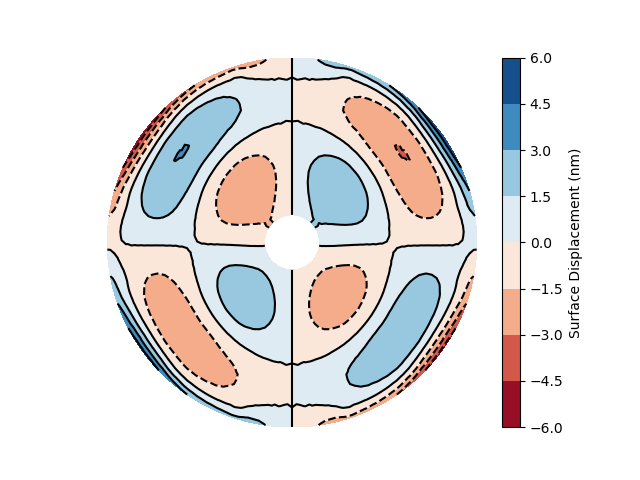

In [9]:
components = pca.transform([zsurf])
filtered = pca.inverse_transform(components)
resid = zsurf - filtered
fig = plot_phase_surface(resid[0])
#fig = plot_phase_surface(zsurf)

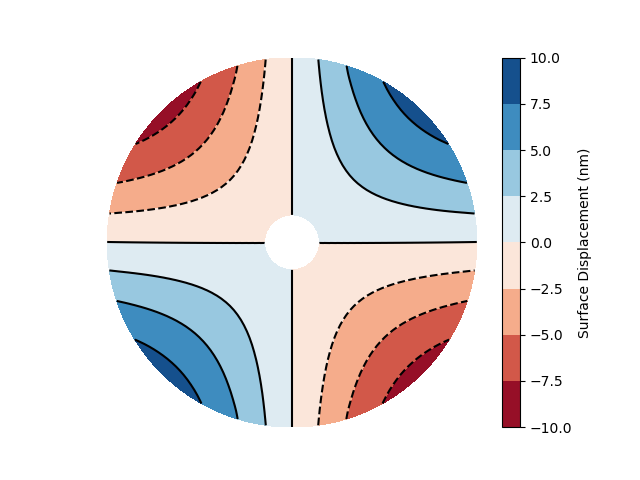

In [10]:
fig = plot_phase_surface(pca.components_[0] / pca.mean_[0])

In [11]:
# try to create a new surf2act via moore-penrose pseudoinverse. basically an SVD, but more user-friendly.
inv = np.linalg.pinv(act2surf, rcond=0.005)  # Use rcond reject less significant modes
inv

array([[ 0.01138258, -0.00360373, -0.00496378, ...,  0.000808  ,
        -0.00205389, -0.00045526],
       [ 0.01172589, -0.00329555, -0.00508512, ...,  0.00097794,
        -0.00199647, -0.00058501],
       [ 0.01301336, -0.00171241, -0.00542143, ...,  0.00160655,
        -0.00167717, -0.00110039],
       ...,
       [ 0.00215474, -0.00104119, -0.00163133, ...,  0.01354139,
         0.00092316, -0.00508811],
       [ 0.00160739, -0.00167701, -0.00110903, ...,  0.01302066,
        -0.00169745, -0.00540685],
       [ 0.0009788 , -0.00197857, -0.00057477, ...,  0.011732  ,
        -0.0032882 , -0.00507952]], shape=(3222, 104))

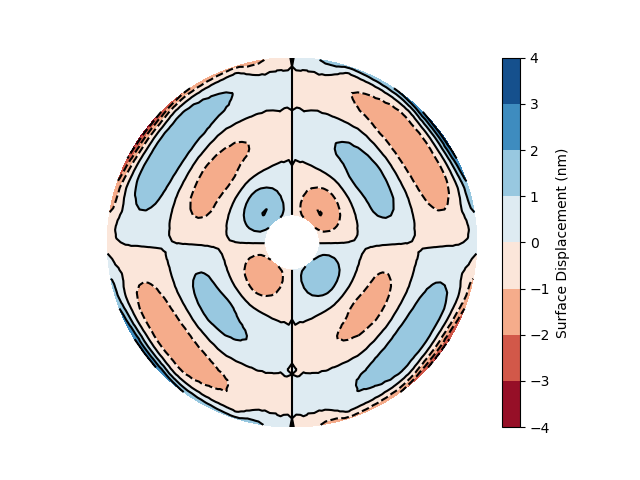

In [12]:
# check quality of the fitted forces using the pseudoinverse matrix
inv_act = zsurf @ inv
inv_resid = zsurf - inv_act @ act2surf
fig = plot_phase_surface(inv_resid)

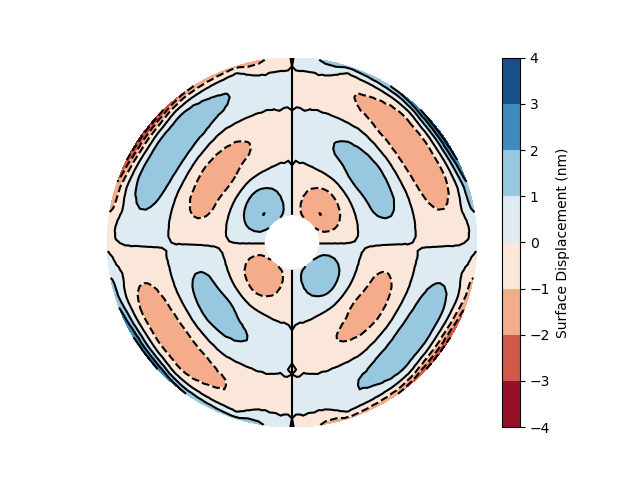

In [13]:
# check quality of the fitted forces using the original 32-mode SVD matrix
svd_act = zsurf @ surf2act
svd_resid = zsurf - svd_act @ act2surf
fig = plot_phase_surface(svd_resid)

In [14]:
# max required force is similar for both so the pseudoinverse
# is a good reconstruction of what we have been using
np.abs(inv_act).max(), np.abs(svd_act).max()

(np.float64(5.940151553648139), np.float64(5.927839691641305))

In [15]:
buddy_forces = [
    -22.5, -25.8, -15.3, 65.5, 48.8, -33.6, 51.4, 100.7, 126.6, 17.4, 24.5, 120.2, 135.7, -27.5, 8.9,
	-13.8, 63.4, 85.9, -8.9, 86.4, -35.8, 65.8, 92.9, 34.0, 47.8, 8.6, 71.7, 75.2, 38.1, 46.3,
	21.5, 29.5, 8.3, 2.8, 52.1, 24.7, -6.0, 10.4, 55.3, 40.9, 38.0, 43.8, 51.4, 49.5, 67.1,
	75.6, 62.9, 51.2, 55.5, -10.2, 13.0, 32.4, -10.8, -14.5, -11.5, 75.1,
    52.7, -11.9, 52.4, 94.2, 117.4, 49.8, 22.7, 101.8, 134.3, 31.3, 9.3,
	-28.5, 27.1, 72.7, 16.9, 59.9, -88.8, 10.3, 60.3, 9.3, 13.9, -8.7, 60.9, 60.3, 50.1, 98.4,
	86.8, 66.0, 16.4, 8.8, 94.4, 93.0, 40.1, 20.4, 47.7, 42.1, 35.9, 12.3, 42.7, 25.4, 43.6,
	30.5, 55.8, 43.5, 15.0, -11.2, 13.7, 23.6
]

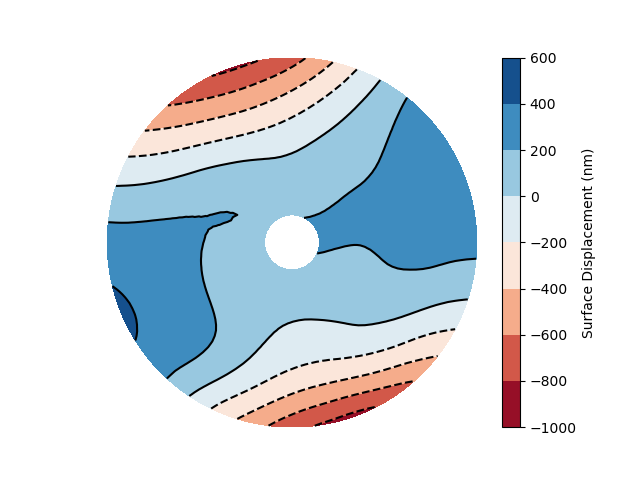

In [16]:
buddy_surf = buddy_forces @ act2surf
fig = plot_phase_surface(buddy_surf)

In [17]:
np.min(buddy_forces), np.max(buddy_forces), np.mean(buddy_forces), np.std(buddy_forces)

(np.float64(-88.8),
 np.float64(135.7),
 np.float64(38.03076923076923),
 np.float64(40.496707076300275))

In [18]:
datadir = Path("/Users/tim/MMT/wfsdat/20250915")
df = pd.read_csv(datadir / "reanalyze_results.csv")

coords = []
for fn in df["file"]:
    with fits.open(datadir / fn) as hdul:
        coords.append(f"{(hdul[0].header["CATRA"], hdul[0].header["CATDEC"])}")
df["coords"] = coords
df = df.set_index(pd.DatetimeIndex(df['time'], name='ut'))

with open(datadir / "wfs.log") as file:
    content = file.read()

cleared_times = []

for line in content.splitlines():
    if "...Clearing forces: OK" in line:
        time, _, _, message = line.split(" - ")
        dt = datetime.strptime(time, "%Y-%m-%d %H:%M:%S,%f")
        # Arizona does not observe daylight saving time, so use 'America/Phoenix'
        arizona = pytz.timezone('America/Phoenix')
        dt_local = arizona.localize(dt)
        dt_utc = dt_local.astimezone(pytz.utc)

        cleared_times.append(dt_utc)
print(len(cleared_times))

0


In [19]:
g = df.groupby("coords")
g.coords.describe()

,count,unique,top,freq
coords,,,,
"(0.89039722, 29.27825)",86,1,"(0.89039722, 29.27825)",86
"(1.68645278, 49.05674167)",36,1,"(1.68645278, 49.05674167)",36
"(17.90429444, 65.12284444)",152,1,"(17.90429444, 65.12284444)",152
"(20.34867222, 38.22308333)",21,1,"(20.34867222, 38.22308333)",21
"(21.630475, 55.13731944)",188,1,"(21.630475, 55.13731944)",188
"(22.12638889, 55.48577778)",8,1,"(22.12638889, 55.48577778)",8
"(22.61768056, 34.41887778)",3,1,"(22.61768056, 34.41887778)",3
"(22.61901944, 34.43666667)",50,1,"(22.61901944, 34.43666667)",50
"(23.31799167, -8.47780556)",88,1,"(23.31799167, -8.47780556)",88


In [20]:
g.first().sort_values('file')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms
coords,,,,,,,,,,,,,,,,,,,,,
"(22.12638889, 55.48577778)",2025-09-15T03:29:52,mmirs,mmirs_wfs_0007.fits,30.0,1.2174,36.111856,55.229879,15,15.27,15.39,...,178.989581,254.003401,0.648039,0.729224,0.701540,0.789427,0.090480,3.935770,2071.718263,1115.696901
"(17.90429444, 65.12284444)",2025-09-15T03:39:52,mmirs,mmirs_wfs_0015.fits,30.0,1.2705,-19.498221,51.915431,15,15.30,15.28,...,265.001102,235.997223,0.619942,0.715708,0.672361,0.776225,0.083816,3.898893,914.121586,1244.971208
"(20.34867222, 38.22308333)",2025-09-15T06:15:00,mmirs,mmirs_wfs_0172.fits,30.0,1.1202,-66.482390,63.217262,15,14.23,14.50,...,246.995687,225.997768,0.788624,0.844204,0.805981,0.862784,0.096557,4.253362,1687.480610,1288.011269
"(23.31799167, -8.47780556)",2025-09-15T06:40:06,mmirs,mmirs_wfs_0193.fits,30.0,1.3150,170.447845,49.504780,14,14.10,14.28,...,251.000898,233.010354,0.843219,0.993793,0.819521,0.965863,0.084250,4.586056,719.254617,1165.901968
"(21.630475, 55.13731944)",2025-09-15T07:52:24,mmirs,mmirs_wfs_0281.fits,30.0,1.2215,323.599433,54.948773,15,13.91,14.56,...,221.982136,231.009910,0.807341,0.910318,0.829633,0.935453,0.021355,4.352060,844.554975,1576.351020
"(22.61768056, 34.41887778)",2025-09-15T09:59:29,mmirs,mmirs_wfs_0469.fits,30.0,1.4093,289.270506,45.199480,14,13.55,14.28,...,223.983264,249.020846,0.798936,0.981553,0.791467,0.972378,0.056268,4.551662,560.888330,1604.414211
"(22.61901944, 34.43666667)",2025-09-15T10:03:35,mmirs,mmirs_wfs_0472.fits,30.0,1.4294,289.551172,44.395300,14,13.46,14.17,...,247.003874,237.000611,0.793042,0.982626,0.788016,0.976399,0.116008,4.642181,834.684020,1251.557921
"(0.89039722, 29.27825)",2025-09-15T10:44:41,mmirs,mmirs_wfs_0522.fits,30.0,1.1214,273.711838,63.096380,14,13.17,14.00,...,223.004034,243.008434,0.697683,0.747333,0.747339,0.800523,0.190317,3.901064,1565.088999,1501.240301
"(1.68645278, 49.05674167)",2025-09-15T11:54:41,mmirs,mmirs_wfs_0608.fits,30.0,1.1863,313.639673,57.453903,14,13.01,13.78,...,263.985534,235.002242,0.670262,0.742610,0.688110,0.762386,0.180271,3.888163,684.449584,1494.115717


In [21]:
g.get_group('(22.12638889, 55.48577778)')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms,coords
ut,,,,,,,,,,,,,,,,,,,,,
2025-09-15 03:29:52,2025-09-15T03:29:52,mmirs,mmirs_wfs_0007.fits,30.0,1.2174,36.111856,55.229879,15,15.27,15.39,...,254.003401,0.648039,0.729224,0.701540,0.789427,0.090480,3.935770,2071.718263,1115.696901,"(22.12638889, 55.48577778)"
2025-09-15 03:30:24,2025-09-15T03:30:24,mmirs,mmirs_wfs_0008.fits,30.0,1.2164,36.048255,55.297042,15,15.26,15.44,...,254.007141,0.826209,0.929257,0.792085,0.890877,0.200745,4.491656,2412.376320,1958.716939,"(22.12638889, 55.48577778)"
2025-09-15 03:31:07,2025-09-15T03:31:07,mmirs,mmirs_wfs_0009.fits,30.0,1.2151,35.963412,55.385769,15,15.25,15.44,...,254.989998,0.617567,0.694147,0.662045,0.744141,0.141143,3.840311,2036.252331,1125.442953,"(22.12638889, 55.48577778)"
2025-09-15 03:31:39,2025-09-15T03:31:39,mmirs,mmirs_wfs_0010.fits,30.0,1.2141,35.898803,55.452707,15,15.23,15.44,...,253.995359,0.695721,0.781606,0.750715,0.843389,0.217414,4.079667,1182.762732,1100.592180,"(22.12638889, 55.48577778)"
2025-09-15 03:32:11,2025-09-15T03:32:11,mmirs,mmirs_wfs_0011.fits,30.0,1.2131,35.833711,55.519504,15,15.19,15.44,...,253.987423,0.609237,0.684108,0.639015,0.717545,0.177611,3.813143,545.077658,1159.198418,"(22.12638889, 55.48577778)"
2025-09-15 03:32:44,2025-09-15T03:32:44,mmirs,mmirs_wfs_0012.fits,30.0,1.2122,35.768276,55.586216,15,15.18,15.44,...,254.500864,0.554919,0.622837,0.616558,0.692019,0.139092,3.649009,823.423731,1058.150969,"(22.12638889, 55.48577778)"
2025-09-15 03:33:16,2025-09-15T03:33:16,mmirs,mmirs_wfs_0013.fits,30.0,1.2112,35.702197,55.652875,15,15.14,15.44,...,255.004211,0.538350,0.603940,0.613366,0.688096,0.141452,3.599042,1259.865370,1312.239929,"(22.12638889, 55.48577778)"
2025-09-15 03:33:49,2025-09-15T03:33:49,mmirs,mmirs_wfs_0014.fits,30.0,1.2102,35.635721,55.719383,15,15.16,15.39,...,256.001405,0.570871,0.640106,0.668485,0.749559,0.202596,3.694957,1243.289281,1056.148688,"(22.12638889, 55.48577778)"


In [22]:
forces = []
for fn in df["file"]:
    forcefile = datadir / (fn + ".forces")
    if forcefile.exists():
        forces.append(np.loadtxt(forcefile)[:, 1])

total_forces = np.sum(forces, axis=0)

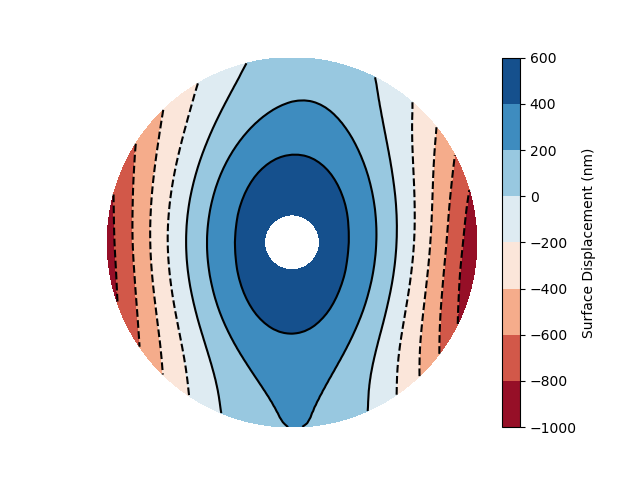

In [28]:
final_surf = total_forces @ act2surf
fig = plot_phase_surface(final_surf)


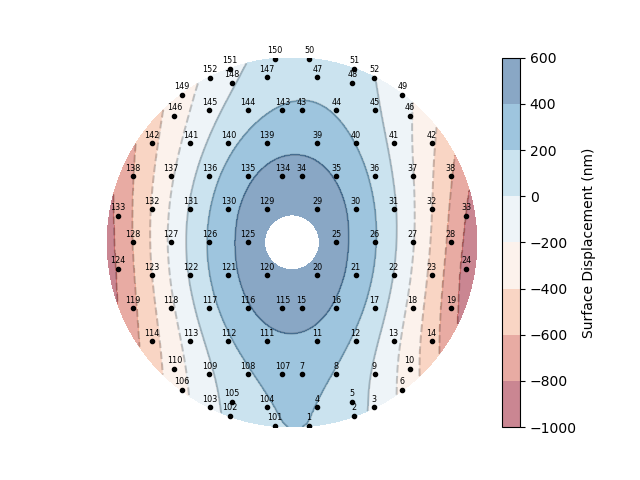

In [44]:
fig = plot_force_influence(total_forces)

In [40]:
total_forces.min(), total_forces.max(), total_forces.mean(), total_forces.std(), actcoor[total_forces.argmax()]['act_i'], actcoor[total_forces.argmin()]['act_i']

(np.float64(-42.50000000000007),
 np.float64(34.90000000000001),
 np.float64(0.07596153846153673),
 np.float64(16.276253911239408),
 np.int64(22),
 np.int64(24))

In [25]:
df

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms,coords
ut,,,,,,,,,,,,,,,,,,,,,
2025-09-15 03:29:52,2025-09-15T03:29:52,mmirs,mmirs_wfs_0007.fits,30.0,1.2174,36.111856,55.229879,15,15.27,15.39,...,254.003401,0.648039,0.729224,0.701540,0.789427,0.090480,3.935770,2071.718263,1115.696901,"(22.12638889, 55.48577778)"
2025-09-15 03:30:24,2025-09-15T03:30:24,mmirs,mmirs_wfs_0008.fits,30.0,1.2164,36.048255,55.297042,15,15.26,15.44,...,254.007141,0.826209,0.929257,0.792085,0.890877,0.200745,4.491656,2412.376320,1958.716939,"(22.12638889, 55.48577778)"
2025-09-15 03:31:07,2025-09-15T03:31:07,mmirs,mmirs_wfs_0009.fits,30.0,1.2151,35.963412,55.385769,15,15.25,15.44,...,254.989998,0.617567,0.694147,0.662045,0.744141,0.141143,3.840311,2036.252331,1125.442953,"(22.12638889, 55.48577778)"
2025-09-15 03:31:39,2025-09-15T03:31:39,mmirs,mmirs_wfs_0010.fits,30.0,1.2141,35.898803,55.452707,15,15.23,15.44,...,253.995359,0.695721,0.781606,0.750715,0.843389,0.217414,4.079667,1182.762732,1100.592180,"(22.12638889, 55.48577778)"
2025-09-15 03:32:11,2025-09-15T03:32:11,mmirs,mmirs_wfs_0011.fits,30.0,1.2131,35.833711,55.519504,15,15.19,15.44,...,253.987423,0.609237,0.684108,0.639015,0.717545,0.177611,3.813143,545.077658,1159.198418,"(22.12638889, 55.48577778)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15 12:13:43,2025-09-15T12:13:43,mmirs,mmirs_wfs_0639.fits,30.0,1.2289,312.089849,54.463830,14,13.13,13.78,...,234.012088,0.692493,0.783655,0.731733,0.828062,0.094519,4.000656,286.822316,1517.086945,"(1.68645278, 49.05674167)"
2025-09-15 12:14:16,2025-09-15T12:14:16,mmirs,mmirs_wfs_0640.fits,30.0,1.2302,312.052663,54.375156,14,13.13,13.78,...,234.007206,0.674260,0.763506,0.725705,0.821762,0.077418,3.945329,287.708133,1495.153155,"(1.68645278, 49.05674167)"
2025-09-15 12:14:48,2025-09-15T12:14:48,mmirs,mmirs_wfs_0641.fits,30.0,1.2315,312.018288,54.292254,14,13.09,13.78,...,234.003073,0.696082,0.788717,0.736032,0.833983,0.095414,4.014583,276.353452,1494.480302,"(1.68645278, 49.05674167)"


In [39]:
actcoor

act_i,act_x,act_y,act_type
int64,float64,float64,int64
1,297.9,-3207.0,0
2,1085.0,-3033.0,0
3,1441.0,-2880.0,0
4,444.0,-2883.0,0
5,1054.0,-2787.0,0
6,1928.0,-2573.0,0
7,166.4,-2306.0,0
8,776.7,-2306.0,1
9,1442.0,-2306.0,1
